# Scaling Analysis

In [1]:
from __future__ import annotations

import json
import os
import pathlib
import tomllib

import seaborn
import polars
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_tasks(filepath: pathlib.Path) -> polars.DataFrame:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            if execution_info is None:
                execution_info = {}
            exception_info = task_info.pop('exception')
            if exception_info is None:
                exception_info = {}
            task_info = {**task_info, **execution_info, **exception_info}
            tasks.append(task_info)

    return polars.DataFrame(tasks)

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.jsonl'):
        method, run = str(tasks_path.relative_to(directory).parent).split('/')

        method = {'baseline': 'Baseline', 'proxystore': 'ProxyStore'}[method]
        workers = int(run.split('-')[0])
    
        tasks = load_tasks(tasks_path)

        start_time = tasks['submit_time'].min()
        end_time = tasks['received_time'].max()
        runtime = end_time - start_time
    
        run_info = {
            'method': method,
            'workers': workers,
            'runtime': runtime,
            'throughput': len(tasks) / runtime,
        }
        runs.append(run_info)

    return polars.DataFrame(runs)

In [3]:
data = load_data(pathlib.Path('runs/scaling-noop'))
data

method,workers,runtime,throughput
str,i64,f64,f64
"""Baseline""",4,58.52686,170.878805
"""Baseline""",64,59.879933,167.685559
"""Baseline""",32,59.308997,168.743369
"""Baseline""",8,59.002289,169.518848
"""Baseline""",1,166.860967,59.936126
"""Baseline""",2,108.236125,92.399834
"""Baseline""",104,77.782894,128.897235
"""Baseline""",16,58.377266,171.350951
"""Baseline""",208,116.377283,87.130407


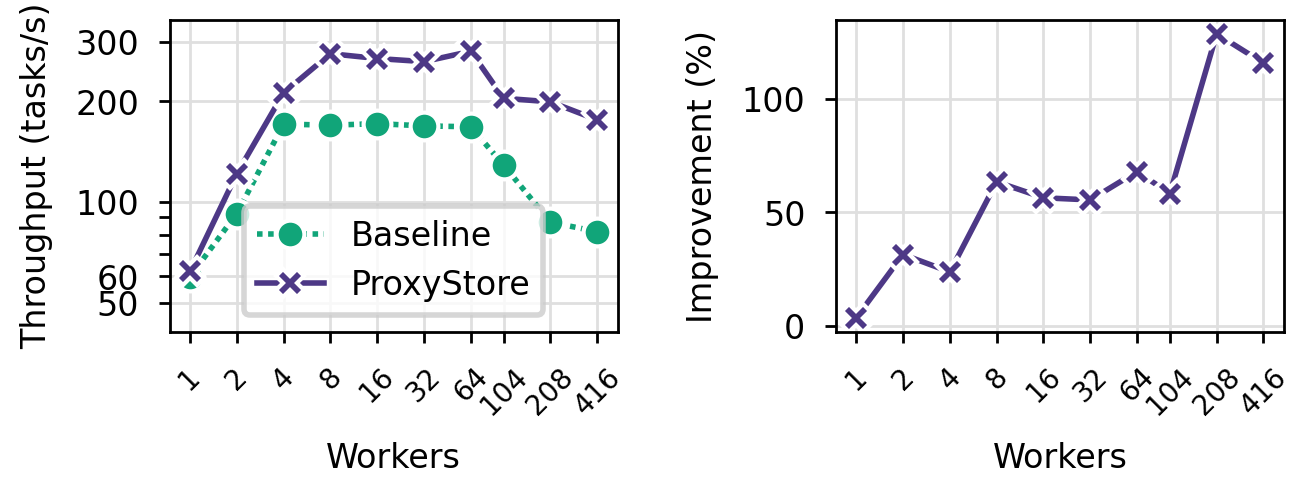

In [4]:
fig, axs = plt.subplots(1, 2)

xticks = list(sorted(set(data['workers'].to_list())))
yticks = [50, 60, 100, 200, 300]

dashes = {'Baseline': (1, 1), 'ProxyStore': ()}
markers = {'Baseline': 'o', 'ProxyStore': 'X'}
palette = {'Baseline': '#11A579', 'ProxyStore': '#4D3886'}

handle = seaborn.lineplot(
    data,
    x="workers",
    y="throughput",
    hue="method",
    hue_order=["Baseline", "ProxyStore"],
    style="method",
    dashes=dashes,
    markers=markers,
    linewidth=1,
    markersize=5,
    palette=palette,
    ax=axs[0],
)
handle.get_legend().set_title(None)
handle.set(
    xscale='log',
    yscale='log',
    xlabel='Workers',
    ylabel='Throughput (tasks/s)',
    ylim=(41, 350),
)
handle.set_yticks(yticks)
handle.set_yticklabels([str(y) for y in yticks])
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks], rotation=45, size=5)
axs[0].tick_params(axis='x', which='minor', bottom=False)

summary = data.drop('runtime').pivot('method', values='throughput')
summary = summary.with_columns(
    (100 * (polars.col('ProxyStore') - polars.col('Baseline')) / polars.col('Baseline')).alias('improvement'),
    polars.lit('ProxyStore').alias('method'),
)

handle = seaborn.lineplot(
    summary,
    x="workers",
    y="improvement",
    hue='method',
    style="method",
    markers=markers,
    linewidth=1,
    markersize=5,
    palette=palette,
    ax=axs[1],
)
handle.get_legend().remove()
handle.set(
    xscale='log',
    xlabel='Workers',
    ylabel='Improvement (%)',
    # ylim=(-5, 65),
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks], rotation=45, size=5)
axs[1].tick_params(axis='x', which='minor', bottom=False)

fig.tight_layout(w_pad=2)
fig.set_size_inches(3.35, 1)
fig.savefig('figures/scaling.pdf')